---
# Optical Character Recognition via Morphology
---

Scanning a document produces an image of that document, represented as an array of pixels.  While written information may be present in the image, it is not explicitly represented as such, and cannot easily be searched or indexed in such a form.  Optical Character Recognition (OCR) refers to the ability to detect and extract the letters and other characters present in an image of a document so as to produce a transcription of the text therein.  Here I use a straightforward application of morphology tools. It can achieve reasonable success under ideal conditions:  when the text in the target document matches the provided templates closely in font and size.

In [159]:
import cv2 as cv
import numpy as np
from scipy.ndimage import label
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.measure import regionprops, regionprops_table, moments, moments_central, moments_normalized, moments_hu
from skimage.morphology import (erosion, dilation, closing, opening, skeletonize, thin, disk, binary_closing)
from skimage import img_as_bool, io, color
from skimage.color import rgb2gray
import matplotlib as mpl
import math
mpl.rc('image', cmap='gray')

def imshow(img,cmap=None):
    plt.imshow(img)
    plt.axis('off')
    if cmap:
        plt.set_cmap(cmap)
    plt.show()

Below is a sample text we can try to recognize.  It has a simple monospaced font and bold characters.

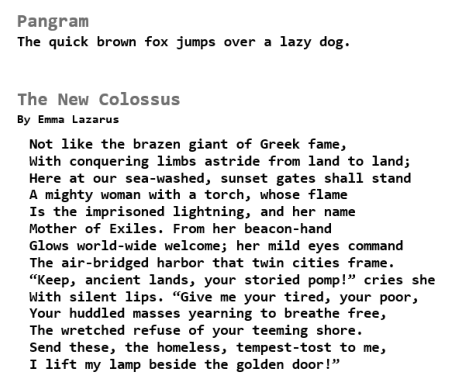

In [160]:
text = cv.imread('bold.png',0).astype(np.float32)/255.0
imshow(text)
tb = text < 0.5  # binarized text

We can apply our connected components labeling technique to identify individual letters.  A quick look at the results reveals a few problems:  Some of the components are non-letter characters like punctuation.  The lower-case i and j are actually two components each.  More subtly, because the labeling method applies labels in raster scan order, taller characters are numbered out of sequence with the shorter letters surrounding them.  You can see this in the different colorings in the visualization below.  The character 'd' in dog is label 15, right before the capital 'T' which is label 16.

637 637


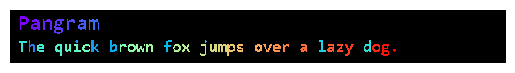

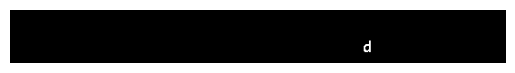

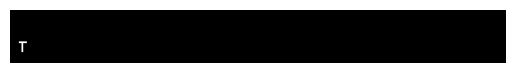

In [161]:
def show_labels(lbl,nlbl=None,cmap='rainbow'):
    cmap = mpl.colormaps[cmap]
    cmap.set_under(color="black")
    plt.imshow(lbl,cmap=cmap,interpolation='none',vmin=1,vmax=nlbl)
    plt.axis('off')
    plt.show()
    
lbl,nlbl = label(tb,structure=np.ones((3,3)))
print(lbl.max(),nlbl)
show_labels(lbl[:60])
imshow(lbl[:60]==15)
imshow(lbl[:60]==16)

### Label By Rows

Below is an implementation of a function to apply morphological techniques. 

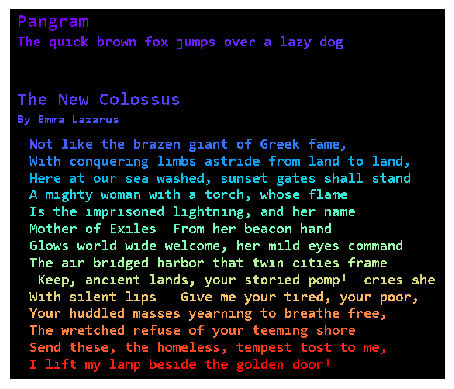

In [162]:
def labelByRows(b,minsize=-1,se=np.ones((3,3))):
    lbl,nlbl = label(b,se)
    
    # first filter out regions below the minimum area
    rgn = regionprops(lbl)
    area = np.array([cc.area for cc in rgn])
    big = (area>minsize)
    newlbl = np.append(0,np.cumsum(big)*big)  # zero at beginning is for background component
    #print(newlbl,nlbl)
    lbl = newlbl[lbl]
    rgn = regionprops(lbl)  # do this again since we've changed the labels
    nlbl = newlbl.max()
    #show_labels(lbl)
    #print(nlbl)
    
    # now identify rows and sort regions left to right within rows
    b2 = dilation(b,np.ones((1,2*b.shape[1])))  #use dilation to stretch horizontally, so elements cluster together
    lbl2,nlbl2 = label(b2)
    cx = np.array([cc.centroid[1] for cc in rgn])
    #print("cx",cx)
    relbl = np.zeros(nlbl+1,dtype=np.int32)  # +1 for background   #rarray of the new labels
    
    for i in range(1,nlbl2+1):  #each iteration reorders a single row 
        rowlbl = np.unique(lbl[lbl2==i])
        rowlbl = rowlbl[rowlbl!=0]  # ignore the background
        order = np.argsort(np.argsort(cx[rowlbl-1]))  # -1 because cx doesn't include background
        # double argsort tells us where each item moves to in the sorted version
        #print("order",order)
        relbl[rowlbl] = rowlbl[order]
        #print("relbl",relbl)
    lbl = relbl[lbl]  #applies the new labels
    #show_labels(lbl)
    return lbl,nlbl
                  
tlbl,ntlbl = labelByRows(tb,14)
show_labels(tlbl)

### Template Matching

Our first attempt at OCR will employ a simple template match.  To make this practical, we will need examples of each of the letter forms to be recognized.  Here is a second text image containing both cases of all letters of the alphabet.  

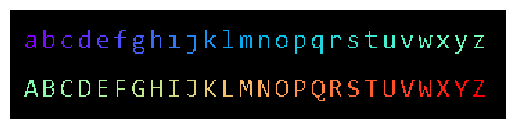

718
566
['P', 'a', 'n', 'g', 'r', 'a', 'm', 'T', 'h', 'e', 'q', 'u', 'i', 'c', 'k', 'b', 'r', 'o', 'w', 'n', 'f', 'o', 'x', 'j', 'u', 'm', 'p', 's', 'o', 'v', 'e', 'r', 'a', 'l', 'a', 'z', 'y', 'd', 'o', 'g', 'T', 'h', 'e', 'N', 'e', 'w', 'C', 'o', 'l', 'o', 's', 's', 'u', 's', 'B', 'y', 'E', 'm', 'm', 'a', 'L', 'a', 'z', 'a', 'r', 'u', 's', 'N', 'o', 't', 'l', 'i', 'k', 'e', 't', 'h', 'e', 'b', 'r', 'a', 'z', 'e', 'n', 'g', 'i', 'a', 'n', 't', 'o', 'f', 'G', 'r', 'e', 'e', 'k', 'f', 'a', 'm', 'e', 'W', 'i', 't', 'h', 'c', 'o', 'n', 'q', 'u', 'e', 'r', 'i', 'n', 'g', 'l', 'i', 'm', 'b', 's', 'a', 's', 't', 'r', 'i', 'd', 'e', 'f', 'r', 'o', 'm', 'l', 'a', 'n', 'd', 't', 'o', 'l', 'a', 'n', 'd', 'H', 'e', 'r', 'e', 'a', 't', 'o', 'u', 'r', 's', 'e', 'a', 'w', 'a', 's', 'h', 'e', 'd', 's', 'u', 'n', 's', 'e', 't', 'g', 'a', 't', 'e', 's', 's', 'h', 'a', 'l', 'l', 's', 't', 'a', 'n', 'd', 'A', 'm', 'i', 'g', 'h', 't', 'y', 'w', 'o', 'm', 'a', 'n', 'w', 'i', 't', 'h', 'a', 't', 'o', 'r', '

In [163]:
# template image
alpha = img_as_bool(cv.imread('alpha.png',0).astype(np.float32)/255.0)

ab = alpha < 0.5
albl,nalbl = labelByRows(ab,14)
show_labels(albl)

#list of alphabet upper and lower case
atag = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

# ground truth text
text = """Pangram 
The quick brown fox jumps over a lazy dog.

The New Colossus
By Emma Lazarus
Not like the brazen giant of Greek fame,
With conquering limbs astride from land to land;
Here at our sea-washed, sunset gates shall stand
A mighty woman with a torch, whose flame
Is the imprisoned lightning, and her name
Mother of Exiles. From her beacon-hand
Glows world-wide welcome; her mild eyes command
The air-bridged harbor that twin cities frame.
“Keep, ancient lands, your storied pomp!” cries she
With silent lips. “Give me your tired, your poor,
Your huddled masses yearning to breathe free,
The wretched refuse of your teeming shore.
Send these, the homeless, tempest-tost to me,
I lift my lamp beside the golden door!”"""

#print(len(text))
letters = [c for c in list(text) if (ord(c)>=65 and ord(c)<=90) or (ord(c)>=97 and ord(c)<=122)]
#print(len(letters))
#print(letters)

The basic idea behind template matching is:  erode the target text using a custom structuring element ('footprint') that is shaped like the character to be recognized.  Any pixels that remain following this operation represent a match for the template, by the definition of the erode operation. 

I process the alphabet image into a list of individual templates, one for each character. To make the matching process a little more robust, I use just the skeleton of each character as the template.  (Even so, the templates may not exactly match all examples of the character)  

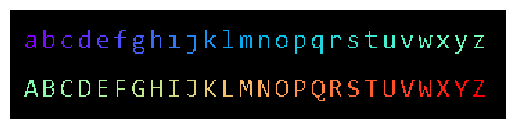

testing:
718
566
['P', 'a', 'n', 'g', 'r', 'a', 'm', 'T', 'h', 'e', 'q', 'u', 'i', 'c', 'k', 'b', 'r', 'o', 'w', 'n', 'f', 'o', 'x', 'j', 'u', 'm', 'p', 's', 'o', 'v', 'e', 'r', 'a', 'l', 'a', 'z', 'y', 'd', 'o', 'g', 'T', 'h', 'e', 'N', 'e', 'w', 'C', 'o', 'l', 'o', 's', 's', 'u', 's', 'B', 'y', 'E', 'm', 'm', 'a', 'L', 'a', 'z', 'a', 'r', 'u', 's', 'N', 'o', 't', 'l', 'i', 'k', 'e', 't', 'h', 'e', 'b', 'r', 'a', 'z', 'e', 'n', 'g', 'i', 'a', 'n', 't', 'o', 'f', 'G', 'r', 'e', 'e', 'k', 'f', 'a', 'm', 'e', 'W', 'i', 't', 'h', 'c', 'o', 'n', 'q', 'u', 'e', 'r', 'i', 'n', 'g', 'l', 'i', 'm', 'b', 's', 'a', 's', 't', 'r', 'i', 'd', 'e', 'f', 'r', 'o', 'm', 'l', 'a', 'n', 'd', 't', 'o', 'l', 'a', 'n', 'd', 'H', 'e', 'r', 'e', 'a', 't', 'o', 'u', 'r', 's', 'e', 'a', 'w', 'a', 's', 'h', 'e', 'd', 's', 'u', 'n', 's', 'e', 't', 'g', 'a', 't', 'e', 's', 's', 'h', 'a', 'l', 'l', 's', 't', 'a', 'n', 'd', 'A', 'm', 'i', 'g', 'h', 't', 'y', 'w', 'o', 'm', 'a', 'n', 'w', 'i', 't', 'h', 'a', 't', 'o

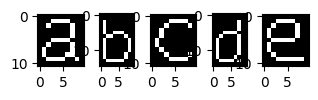

In [177]:
#Here I use an alpha image to create individual letter templates (and display some of them)

#read image
im = cv.imread('alpha.png',0).astype(np.float32)/255.0

#binarize image
ab = im < 0.5

albl,nalbl = labelByRows(ab,14)
show_labels(albl)
rgn = regionprops(albl)

#define padding and boundary
area = np.array([cc.area for cc in rgn])
box = np.array([cc.bbox for cc in rgn]) #box from regionprops

#create empty array
sk = []


for i in range(52):
    sk.append(thin(ab[box[i, 0]: box[i, 2], box[i, 1]: box[i, 3]])) #will be a boolean matrix in shape of letter

print("testing:")
for i in range(5):
    plt.subplot(6, 9, i+1+ (i>25))
    plt.imshow(np.pad(sk[i], (1, 1)))
#plt.show()

# ground truth text
text = """Pangram 
The quick brown fox jumps over a lazy dog.

The New Colossus
By Emma Lazarus
Not like the brazen giant of Greek fame,
With conquering limbs astride from land to land;
Here at our sea-washed, sunset gates shall stand
A mighty woman with a torch, whose flame
Is the imprisoned lightning, and her name
Mother of Exiles. From her beacon-hand
Glows world-wide welcome; her mild eyes command
The air-bridged harbor that twin cities frame.
“Keep, ancient lands, your storied pomp!” cries she
With silent lips. “Give me your tired, your poor,
Your huddled masses yearning to breathe free,
The wretched refuse of your teeming shore.
Send these, the homeless, tempest-tost to me,
I lift my lamp beside the golden door!”"""
print(len(text))
letters = [c for c in list(text) if (ord(c)>=65 and ord(c)<=90) or (ord(c)>=97 and ord(c)<=122)]
print(len(letters))
#print(letters)

Here I apply some of these templates using the `erosion` function.  A plotting function then shows us where the matches lie.

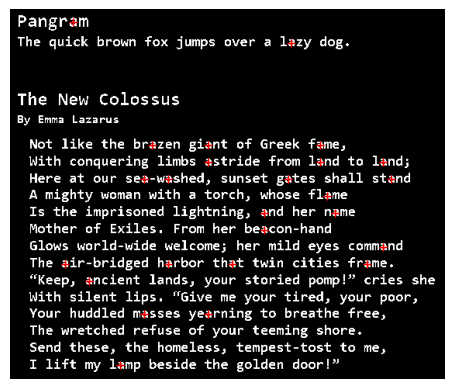

In [165]:
def plotHits(hi,hj,img):
    '''Plot the locations of template hits, given their coordinates and the underlying image'''
    plt.imshow(img)
    plt.axis('off')
    plt.plot(hj,hi,'r+')
    plt.show()
    


#kernel = np.ones((5,5),np.uint8)
#Using the erosion function
img_erosion = erosion(tb, sk[0])

#imshow(img_erosion)
rows, cols = np.nonzero(img_erosion)

plotHits(rows, cols, tb)

# Details:  I call erosion using the chosen template as the footprint.  
# The result is mostly black, but there should be a few white pixels representing the hits.



Next, I systematically match every template against the entire image, and record for every match the corresponding component.  If more than one template matches to a single component, I will break ties by looking at the total number of pixels in the template.  Bigger templates represent a more complete match -- thus 'c is less complete than 'o', which in turn is less complete than 'p'.  If no templates match to a particular component, I leave it blank (for now).

I create a function that takes a label image and a list of templates, and returns a vector with length equal to the number of components, where each element contains the index of the template that gave the most complete match.  Unmatched components will use the value `None`.

Depending on the shape of the template, the point where its center matches may or may not actually be a part of the letter image.  The `footprintOffset` function below gives the adjustment that will take a template match to an actual character pixel.

In [166]:
def footprintOffset(foot):
    '''Figures out the offset between the footprint center and an active point'''

    #fi are rows fj are columns of hits in the template 
    (fi,fj) = erosion(foot,foot).nonzero()

    #ai, aj are where template is true
    (ai,aj) = foot.nonzero()
    return(ai[ai.size//2]-fi,aj[aj.size//2]-fj)


In [167]:
#checks for multiple matches, and keeps the larger letter 
def duplicates(matrix, letters, sk, starting_point=0):
    #print(matrix.shape[0])
    for value in range(starting_point, matrix.shape[0]):
        starting_point += 1
        #print(matrix[value][0])
        for possible_copy in range(value+1, matrix.shape[0]):
            #if (math.isclose(matrix[value][0], matrix[possible_copy][0], rel_tol= .5) and math.isclose(matrix[value][1], matrix[possible_copy][1], rel_tol= .5)):
            if (matrix[value][0] == matrix[possible_copy][0] and matrix[value][1] == matrix[possible_copy][1]):
            #if np.all(matrix[value] == matrix[possible_copy]):
                if (sk[(letters[value]).astype(int)]).sum() > (sk[(letters[possible_copy]).astype(int)]).sum():
                    matrix1 = np.delete(matrix, (possible_copy), axis=0)
                    letters1 = np.delete(letters, possible_copy)
                    return duplicates(matrix1, letters1, sk, starting_point)
                else:
                    matrix2 = np.delete(matrix, (value), axis=0)
                    letters2 = np.delete(letters, possible_copy)
                    return duplicates(matrix2, letters2, sk, starting_point)
    print("new matrix shape:")
    print(matrix.shape)
    return matrix.astype(int), letters

match_templates takes the list of templates, the binary text image, and its component labeling. It produces a vector of indices corresponding to different templates.  There is one index per component. Each element identifies the template that was matched to the corresponding component. 

The implementation will apply each template in turn, using footprintOffset to convert the hit location to find a pixel of the matched component.  If a template matches a component that was already matched before, the template with more pixels in its footprint wins.

In [179]:

def match_templates(list_templates, txt_img, tlbl):
    ntlbl = tlbl.max()

    #components = num_components(txt_img, list_templates)
    #hits = np.zeros((components))
    coords = np.zeros((ntlbl, 2))
    match = np.zeros(ntlbl, dtype=np.int32)-1
    #position = 0

    #looping through each letter in the alphabet (both upper and lowercase)
    for i in range(52):
        (rowsFoot, colsFoot) = footprintOffset(list_templates[i])
        img_erosion = erosion(txt_img, list_templates[i])
        (hi, hj) = img_erosion.nonzero()
        for j in range(hi.size):
            #rowsC = hi[j] + rowsFoot - 1 
            #colsC = hj[j] + colsFoot - 1  
            combined = int(tlbl[hi[j] + rowsFoot, hj[j] + colsFoot]) - 1 #combine the two aspects into one
            coords[combined, 0] = hi[j]
            coords[combined, 1] = hj[j]
            if combined == -1:
                print("error")
            if match[combined] < 0:
                match[combined] = i
            elif list_templates[i].sum() > list_templates[match[combined]].sum():  
                match[combined] = i  #replace with bigger character
    return match, coords
            

#match_templates(sk, tb)
#im2 = cv.imread('alpha.png',0).astype(np.float32)/255.0
im = cv.imread('alpha.png',0).astype(np.float32)/255.0
ab = im < 0.5

#Checking the number of hits:
match, hloc = match_templates(sk, tb, tlbl)
for x in range(5):  #set range equal to number of letters you want to see
    print(atag[x], ' has ', (match==x).sum(), ' hits')



a  has  25  hits
b  has  3  hits
c  has  26  hits
d  has  21  hits
e  has  38  hits


Below is a function to systematically apply all templates to a label image as described above.

I use a simple visualization to display the recognized characters on top of the text image. 



[[ 14.  15.]
 [  0.   0.]
 [ 17.  42.]
 ...
 [459. 390.]
 [  0.   0.]
 [  0.   0.]]
15.0
42.0
54.0
69.0
81.0
97.0
14.0
24.0
54.0
65.0
75.0
85.0
117.0
128.0
138.0
147.0
158.0
189.0
218.0
229.0
240.0
250.0
260.0
281.0
291.0
300.0
353.0
362.0
373.0
384.0
403.0
415.0
425.0
16.0
29.0
40.0
70.0
81.0
120.0
148.0
160.0
200.0
13.0
29.0
41.0
71.0
81.0
91.0
101.0
133.0
142.0
163.0
183.0
194.0
215.0
235.0
245.0
255.0
266.0
297.0
328.0
339.0
347.0
368.0
399.0
410.0
419.0
40.0
61.0
92.0
102.0
111.0
122.0
132.0
144.0
153.0
164.0
174.0
195.0
204.0
215.0
225.0
235.0
255.0
306.0
316.0
349.0
359.0
369.0
390.0
399.0
410.0
419.0
451.0
472.0
481.0
492.0
501.0
30.0
39.0
60.0
112.0
122.0
153.0
173.0
194.0
204.0
214.0
225.0
234.0
276.0
286.0
297.0
316.0
327.0
348.0
358.0
368.0
378.0
389.0
409.0
420.0
441.0
451.0
471.0
491.0
502.0
29.0
51.0
71.0
81.0
102.0
122.0
133.0
143.0
164.0
194.0
215.0
255.0
266.0
277.0
297.0
327.0
338.0
349.0
358.0
368.0
400.0
409.0
420.0
429.0
30.0
40.0
60.0
71.0
80.0
112.0
123.0
153.0


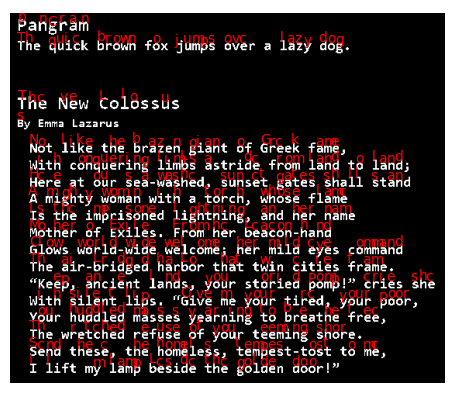

In [170]:
def visualize(match,loc,img):
    '''Shows the matches for each component, the component centroids, and the original image'''
    plt.imshow(img)

    for i in range(match.shape[0]):
        #print("one",i,match[i],loc[i,1]-5,loc[i,0]-5,atag[match[i]])
        if match[i]>=0:
            #print("two",i,match[i],loc[i,1]-5,loc[i,0]-5,atag[match[i]])
            #print(i)
            print(loc[i,1])
            plt.text(loc[i,1]-6,loc[i,0]-5,atag[match[i]],color='r') ##Original Code!!
    plt.axis('off')
    plt.show()


#print(hloc)

#letter, coords = match_templates(sk, tb, tlbl)  #tb
visualize(match, hloc, tb) 

# Details:  match is the result from your template matcher.  
# loc is a Cx2 set of coordinates of the component centroids.

In [171]:
# from https://stackoverflow.com/questions/2460177/edit-distance-in-python:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]


#uses the Levenshtein distance on strings to compute the percentage of correct letters
def grade_transcription(s,gt):
    '''measures the number of errors in a transcription'''
    s2 = s.replace(" ","")
    gt2 = gt.replace(" ","")
    d = levenshteinDistance(s2,gt2)
    print(d,"errors in",len(gt2),"characters:",1-d/len(gt2),"% correct")
    

letters, coords = match_templates(sk, tb, tlbl)
result = ''
atag = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
for value in letters:
    if value != None:
        result += atag[value] 
    else:
        result += '*'
text = """Pangram 
The quick brown fox jumps over a lazy dog.

The New Colossus
By Emma Lazarus
Not like the brazen giant of Greek fame,
With conquering limbs astride from land to land;
Here at our sea-washed, sunset gates shall stand
A mighty woman with a torch, whose flame
Is the imprisoned lightning, and her name
Mother of Exiles. From her beacon-hand
Glows world-wide welcome; her mild eyes command
The air-bridged harbor that twin cities frame.
“Keep, ancient lands, your storied pomp!” cries she
With silent lips. “Give me your tired, your poor,
Your huddled masses yearning to breathe free,
The wretched refuse of your teeming shore.
Send these, the homeless, tempest-tost to me,
I lift my lamp beside the golden door!”"""
grade_transcription(text, result)

228 errors in 581 characters: 0.6075731497418244 % correct


Potential ideas to improve results:
* Dilate the target components to make them slightly bigger.  This will make templates more likely to match.
* Resize the image to make everything twice as big.  This will give you more freedom to adjust the erosion of the templates, and/or the dilation of the mask.
* Try making the templates a little bigger to match the larger font size in the heading.

### Statistical Component Matching

Here I try an alternative techniqe, also using morphological methods.  In this case, I match characters based on statistics computed from the connected components.  In theory, each letter is consistent in shape so their statistical properties should be the same.  In practice there is some variation due to aliasing, etc.

For each component, I compute a vector of identifying statistics.  Do this for both the alphabet image and the target text.  Then, using Euclidean distance or some other metric, I determine for each target character the template character with the most similar statistics vector.  This match determines the component's label.  I analyze the results using the same techniques as before.


In [176]:
def nnclass(astat,tstat):
    '''returns the index of each t vector of the closest a vector'''
    d = distance_matrix(astat,tstat)  # args are MxK and NxK
    #print(d.shape)
    #imshow(d)
    return d.argmin(0).astype(np.int32)

#alpha = img_as_bool(cv.imread('alpha.png',0).astype(np.float32)/255.0)
#ab = alpha < 0.5
labels, nalbl = labelByRows(ab, 14)

props = regionprops(labels)

a = np.array([cc.perimeter for cc in props])
b = np.array([cc.orientation for cc in props])
c = np.array([cc.eccentricity for cc in props])
d = np.array([cc.area for cc in props])
codes = np.array([range(97, 123), range(65, 91)]).ravel()

#text = cv.imread('bold.png',0).astype(np.float32)/255.0
#tb = text < 0.5  # binarized text
text_label, text_nalbl = labelByRows(tb, 14)
text_props = regionprops(text_label)

a2 = np.array([cc.perimeter for cc in text_props])
b2 = np.array([cc.orientation for cc in text_props])
c2 = np.array([cc.eccentricity for cc in text_props])
d2 = np.array([cc.area for cc in text_props])
codes2 = np.array([range(97, 123), range(65, 91)]).ravel()

stack = np.stack((a/d, b,c))
text_stack = np.stack((a2/d2, b2,c2))

# get centroid of second object
centroid = props[1].centroid
# get eccentricity of first object
ecc = props[0].eccentricity
matrix = np.stack([rp.centroid for rp in props])

swap_dims = nnclass(stack.T, text_stack.T)


#Testing results
result = ''
atag = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
for value in swap_dims:
    if value != None:
        result += atag[value] 
    else:
        result += '*'
print(result)
text = """Pangram 
The quick brown fox jumps over a lazy dog.

The New Colossus
By Emma Lazarus
Not like the brazen giant of Greek fame,
With conquering limbs astride from land to land;
Here at our sea-washed, sunset gates shall stand
A mighty woman with a torch, whose flame
Is the imprisoned lightning, and her name
Mother of Exiles. From her beacon-hand
Glows world-wide welcome; her mild eyes command
The air-bridged harbor that twin cities frame.
“Keep, ancient lands, your storied pomp!” cries she
With silent lips. “Give me your tired, your poor,
Your huddled masses yearning to breathe free,
The wretched refuse of your teeming shore.
Send these, the homeless, tempest-tost to me,
I lift my lamp beside the golden door!”"""
grade_transcription(text, result)



# Details: I assemble two matrices of statistical properties, one for the alphabet templates and one for 
# the components in the text image.  Note they have the same size in the second dimension.



(581,)
dRoFrRuzqYkHtRtkrnwufoNjowaKHnarYlYzddnEIkHWYwIelYKiHiRdIwwRLeKRruKNntIttHikHkrYzYuFtHuiHfiraYkfNwHdettkRoukHHrtuIltwkKHhiridafrowlNudtHlNuddHarHYtoHrKYHwNNkaddKouhatFNtHKNkYllKtHudRriIqtdwHuYurttkYtorikdrknNHflHuaIKtkaiudriKouHdliFktutuIdHudkHruYuYWntkHrHfIHtlHhfrnrkarkaHRnukYudNlorhwHrldwtdHwHIRowHdkHrutldadHhiHuuNudzqYYtrkridFYdqNrknrtqNtiriHRiitHhfrYuYKYHadHuRiHHtIYudhddoHrhiHrtYddowajRrtHhNkaettkKtlHHtltdhNtoHuYFnurtiraddfourdHordRnorqoddlHdrHhKYNfYHrHtuItokrHYtkHfrHadzqYrrYtRqHdrHfHNHnfFnoriHHutuINkorYiaudikHhadikHqowHlYNhdtHudHKttnNtiouadIlifiwlYudkaNidatkaIoldHHdonrj
436 errors in 581 characters: 0.24956970740103268 % correct
